In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import hyperdt.benchmarking as benchmarking
from hyperdt.product_space_DT import ProductSpace, ProductSpaceDT
from hyperdt.tree import DecisionTreeClassifier
# from sklearn.tree import DecisionTreeClassifier

INFO: Using numpy backend


In [3]:
NUM_POINTS = 1000
NUM_CLASSES = 4
signatures = [
    # [(2, -1.)],
    # [(2, -.5)],
    # [(2, -.1)],
    # [(2, 0.)],
    # [(2, .1)],
    # [(2, .5)],
    # [(2, 1.)],
    [(3, -1.)],
    [(3, 1.)],
    [(3, -1.), (4, -.5)],
    [(3, -1.), (4, 1.)],
    [(3, -1.), (4, 1.), (5, 0.)],
    [(3, -1.), (4, -.5), (3, .5), (4, 1.)],
    [(3, -1.), (4, -.5), (3, .5), (4, 1.), (5, 0.)],
    # [(6, -1.), (6, -.5), (7, .5), (6, 1.), (6, 0.)]
]

### Boxplots comparing HyperDT and sklearn across signatures

In [4]:
rnd_seeds, psdt_scores_by_signature, dt_scores_by_signature = benchmarking.compute_scores_by_signature(
    signatures, NUM_POINTS, NUM_CLASSES, seed=0, max_depth=3)

100%|██████████| 70/70 [00:58<00:00,  1.20it/s]


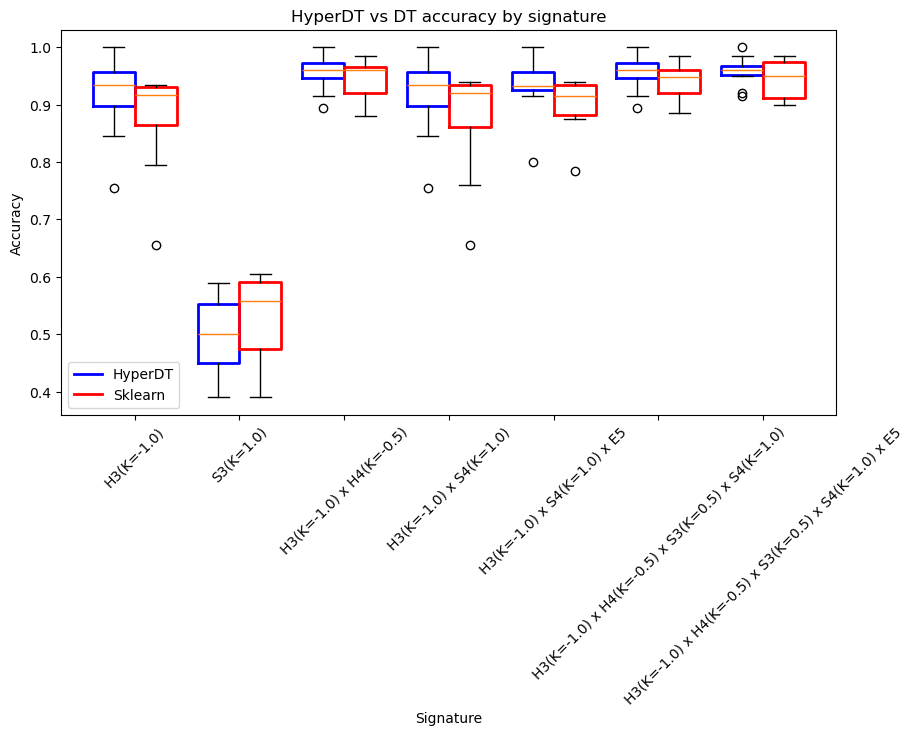

In [5]:
benchmarking.plot_boxplots(signatures, psdt_scores_by_signature, dt_scores_by_signature)

### Comparing average scores across signatures

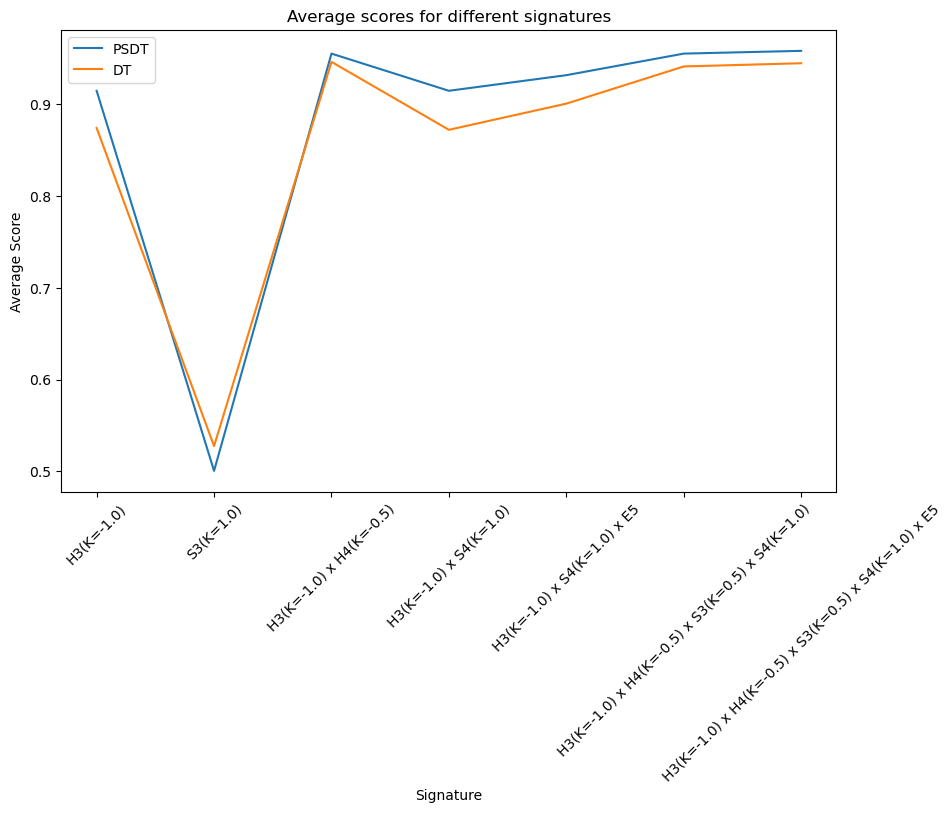

In [6]:
avg_psdt_scores, avg_dt_scores = benchmarking.compute_avg_scores(psdt_scores_by_signature, dt_scores_by_signature)
benchmarking.plot_avg_scores(signatures, avg_psdt_scores, avg_dt_scores)

### Compare HyperDT against sklearn without timelike dims

In [8]:
psdt_scores = []
dt_scores = []

for _ in range(20):
    ps = ProductSpace(signature=[(3, -1.), (4, -.5), (3, .5), (4, 1.), (5, 0.)], seed=None)
    ps.sample_clusters(1000, 4, cov_scale=0.3)
    ps.split_data()

    psdt = ProductSpaceDT(ps.signature, max_depth=3)
    psdt.fit(ps.X_train, ps.y_train)
    psdt_score = psdt.score(ps.X_test, ps.y_test)

    ps.remove_timelike_dims()
    ps.split_data()
    X_train, X_test, y_train, y_test = ps.X_train, ps.X_test, ps.y_train, ps.y_test

    dt = DecisionTreeClassifier(max_depth=3)
    dt.fit(X_train, y_train)
    dt_score = dt.score(X_test, y_test)

    psdt_scores.append(psdt_score)
    dt_scores.append(dt_score)

print(f'PSDT: {np.mean(psdt_scores)}, DT: {np.mean(dt_scores)}')

PSDT: 0.9605, DT: 0.9462499999999998


## Debugging

### Product space where one component contains significant data

Data generation process seems to work well. PSDT outperforms sklearn when the first component is significant.

In [9]:
# Helper methods to check if only the dimensions from the non-zero components are used in DT
def print_node(node):
    print(f'Feature: {node.feature}, Theta: {node.theta}, Value: {node.value}')

def traverse(node):
    print_node(node)
    if node.left is not None:
        traverse(node.left)
    if node.right is not None:
        traverse(node.right)

In [10]:
for zero_dim1, zero_dim2 in [(0, 1), (0, 2), (1, 2)]:
    ps_scores = []
    dt_scores = []
    for _ in range(20):
        try:
            ps = ProductSpace(signature=[(3, -.5), (3, -1.), (3, -2.)], seed=None)
            ps.sample_clusters(1000, 4, cov_scale=0.3)

            ps.zero_out_spacelike_dims(zero_dim1)
            ps.zero_out_spacelike_dims(zero_dim2)
            # print(f'Zero columns: {np.where(np.all(ps.X == 0, axis=0))[0]}')

            # Swap first and third components
            ps.signature[0], ps.signature[2] = ps.signature[2], ps.signature[0]
            ps.X[:, 0:4], ps.X[:, 8:12] = ps.X[:, 8:12], ps.X[:, 0:4].copy()

            ps.split_data()

            psdt = ProductSpaceDT(ps.signature, max_depth=3)
            psdt.fit(ps.X_train, ps.y_train)
            psdt_score = psdt.score(ps.X_test, ps.y_test)

            X_train, X_test, y_train, y_test = ps.X_train, ps.X_test, ps.y_train, ps.y_test
            dt = DecisionTreeClassifier(max_depth=3)
            dt.fit(X_train, y_train)
            dt_score = dt.score(X_test, y_test)

            ps_scores.append(psdt_score)
            dt_scores.append(dt_score)

        except Exception as e:
            print(e)

    print(f'PSDT: {np.mean(ps_scores)}, DT: {np.mean(dt_scores)}')

PSDT: 0.9177499999999998, DT: 0.8729999999999999

PSDT: 0.8713157894736842, DT: 0.8273684210526315
PSDT: 0.7989999999999999, DT: 0.78325


### Product space with only Euclidean components

PSDT performs comparably with sklearn

In [11]:
psdt_scores = []
dt_scores = []

for _ in range(20):
    ps = ProductSpace(signature=[(3, 0.), (4, 0.), (5, 0.)], seed=None)
    ps.sample_clusters(1000, 4, cov_scale=0.3)
    ps.split_data()

    psdt = ProductSpaceDT(ps.signature, max_depth=3)
    psdt.fit(ps.X_train, ps.y_train)
    psdt_score = psdt.score(ps.X_test, ps.y_test)

    X_train, X_test, y_train, y_test = ps.X_train, ps.X_test, ps.y_train, ps.y_test
    dt = DecisionTreeClassifier(max_depth=3)
    dt.fit(X_train, y_train)
    dt_score = dt.score(X_test, y_test)

    psdt_scores.append(psdt_score)
    dt_scores.append(dt_score)

print(f'PSDT: {np.mean(psdt_scores)}, DT: {np.mean(dt_scores)}')

PSDT: 0.85375, DT: 0.85375


### Product space with only hyperbolic components

PSDT underperforms sklearn

In [12]:
psdt_scores = []
dt_scores = []

for _ in range(3):
    ps = ProductSpace(signature=[(3, -1.), (3, -1.)], seed=None)
    ps.sample_clusters(1000, 4, cov_scale=0.3)
    ps.split_data()

    psdt = ProductSpaceDT(ps.signature, max_depth=3)
    psdt.fit(ps.X_train, ps.y_train)
    print(f'PSDT tree:')
    traverse(psdt.tree)
    print('\n')
    psdt_score = psdt.score(ps.X_test, ps.y_test)

    X_train, X_test, y_train, y_test = ps.X_train, ps.X_test, ps.y_train, ps.y_test
    dt = DecisionTreeClassifier(max_depth=3)
    dt.fit(X_train, y_train)
    print(f'DT tree:')
    traverse(dt.tree)
    print('\n')
    dt_score = dt.score(X_test, y_test)

    psdt_scores.append(psdt_score)
    dt_scores.append(dt_score)
    print(f'psdt: {psdt_score}, dt: {dt_score}\n')

print(f'PSDT: {np.mean(psdt_scores)}, DT: {np.mean(dt_scores)}')

PSDT tree:
Feature: 6, Theta: 1.1043759390139318, Value: None
Feature: 2, Theta: 1.8584887318977332, Value: None
Feature: 6, Theta: 1.3974046994524392, Value: None
Feature: None, Theta: None, Value: 0
Feature: None, Theta: None, Value: 1
Feature: 1, Theta: 2.136027200889914, Value: None
Feature: None, Theta: None, Value: 2
Feature: None, Theta: None, Value: 3
Feature: 7, Theta: 1.3077149932592433, Value: None
Feature: None, Theta: None, Value: 1
Feature: 6, Theta: 0.999429035641446, Value: None
Feature: None, Theta: None, Value: 3
Feature: None, Theta: None, Value: 1


DT tree:
Feature: 6, Theta: 0.05418412837420616, Value: None
Feature: 2, Theta: -0.5073158786060346, Value: None
Feature: None, Theta: None, Value: 0
Feature: 1, Theta: -5.94893090068917, Value: None
Feature: None, Theta: None, Value: 2
Feature: None, Theta: None, Value: 3
Feature: 2, Theta: 0.9205099900511767, Value: None
Feature: 6, Theta: 0.8107053039513301, Value: None
Feature: None, Theta: None, Value: 3
Feature: No

### Product space with only spherical components

PSDT underperforms sklearn

In [13]:
psdt_scores = []
dt_scores = []

for _ in range(20):
    ps = ProductSpace(signature=[(3, 1.), (4, 1.), (5, 1.)], seed=None)
    ps.sample_clusters(1000, 4, cov_scale=0.3)
    ps.split_data()

    psdt = ProductSpaceDT(ps.signature, max_depth=3)
    psdt.fit(ps.X_train, ps.y_train)
    psdt_score = psdt.score(ps.X_test, ps.y_test)

    X_train, X_test, y_train, y_test = ps.X_train, ps.X_test, ps.y_train, ps.y_test
    dt = DecisionTreeClassifier(max_depth=3)
    dt.fit(X_train, y_train)
    dt_score = dt.score(X_test, y_test)

    psdt_scores.append(psdt_score)
    dt_scores.append(dt_score)

print(f'PSDT: {np.mean(psdt_scores)}, DT: {np.mean(dt_scores)}')

PSDT: 0.65375, DT: 0.65


## Appendix

### Difference in accuracy scores for different signatures across random seeds

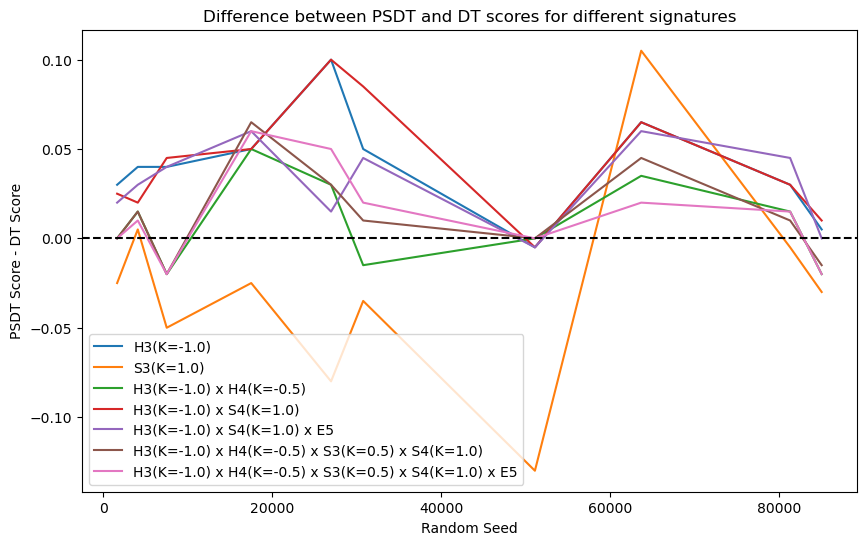

In [14]:
sorted_rnd_seeds, sorted_psdt_scores_by_signature, sorted_dt_scores_by_signature = benchmarking.get_sorted_scores_by_signature(
    rnd_seeds, psdt_scores_by_signature, dt_scores_by_signature)
diff_scores = benchmarking.compute_diff_scores(sorted_psdt_scores_by_signature, sorted_dt_scores_by_signature)
benchmarking.plot_diff_scores(sorted_rnd_seeds, diff_scores, signatures)